In [67]:
import numpy as np
import open3d as o3d
import pathlib
import sys
import math
import itertools
import matplotlib.pyplot as plt

In [68]:
print(f"Numpy version: {np.__version__}")
print(f"Open3D version: {o3d.__version__}")
print(f"Python version: {sys.version[:6]}")

Numpy version: 1.23.5
Open3D version: 0.17.0
Python version: 3.9.16


## Loading in Point cloud data

Problems encountered: Trouble cleaning with scans with a depth perception problem, might need to investigate order of code execution

Todo: Remove more of the floor manually before applying DBSCAN

Trouble with: 
P003, 
P010 (ground isnt cleaned??) 
P011 (weird capture?) 
P013 (ground isnt cleaned??)
P014 (ground isnt cleaned??)
P015 (ground)
P017


P005 / P006 have some spurious points around its edges, especially around the feet.

In [76]:
# Load ply file
path = "./data/P004 2022-01-25 01_23_56.ply"

def load(path: str) -> o3d.cpu.pybind.geometry.PointCloud:
    '''
        Loads a ply file provided a valid path with robust error checking
        
        Checks file path exists and is a ply file that is not empty
        
        Args:
            path: string path to a .ply file
        
        Returns:
            pcd: non-empty point cloud data object
    '''
    
    # checks if file exists
    if not pathlib.Path(path).exists(): 
        raise FileNotFoundError("File not found.")
    
    # checking correct file format
    if pathlib.Path(path).suffix != '.ply':
        raise ValueError(f"Expected a .ply file, got {pathlib.Path(path).suffix}")
    
    # check if file is not empty
    if pathlib.Path(path).stat().st_size == 0:
        raise ValueError("File is empty.")
    
    pcd = o3d.io.read_point_cloud(path)
    
    # checks pt cloud is not empty
    if not np.asarray(pcd.points).size:
        raise ValueError("Point cloud has no points.")
    
    # pts and colors must match (not too important, but mismatches may lead to incorrect results when vis or analysing)
    if np.asarray(pcd.points).shape[0] != np.asarray(pcd.colors).shape[0]:
        raise ValueError("Point cloud has mismatch between points and colors.")
    
    return pcd # should pass all error cases

pcd = load(path)

print("PLY file loaded.")
print('Shape of points', np.asarray(pcd.points).shape)
print('Shape of colors', np.asarray(pcd.colors).shape)

PLY file loaded.
Shape of points (272283, 3)
Shape of colors (272283, 3)


In [51]:
o3d.visualization.draw_geometries([pcd])

In [59]:
import copy

pcd_vis = copy.deepcopy(pcd) # copies original pcd

def viewClustersViaColours(pcd: o3d.cpu.pybind.geometry.PointCloud) -> None:
    '''
        Visualising pcd coloured by cluster applying DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm
        Alter cluster_dbscan() params for different results
            eps: max dist between two samples for them to be considered same neighbourhood
            min_points: min number of points required to form a cluster
    '''
    
    labels = np.array(pcd.cluster_dbscan(eps=0.03, min_points=3, print_progress=True))
    max_label = labels.max()
    print(f"point cloud has {max_label + 1} clusters")
    colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1)) # avoids div error
    colors[labels < 0] = 0 # label=-1 indicates noise
    pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
    o3d.visualization.draw_geometries([pcd])

viewClustersViaColours(pcd_vis)

point cloud has 95 clusters


In [139]:
from ipywidgets import interact, interactive, fixed, interact_manual, Button
from IPython.display import display

# This will hold the final state of the point cloud
final_pcd = None

def create_grid_on_plane(thresh, axis, color):
    lines = []
    colors = []
    for i in np.linspace(-1, 1, 10):  # Adjust these values as per your requirements
        # vertical lines
        start = [i, thresh, -1] if axis == 'y' else ([thresh, i, -1] if axis == 'x' else [-1, i, thresh])
        end = [i, thresh, 1] if axis == 'y' else ([thresh, i, 1] if axis == 'x' else [1, i, thresh])
        lines.append([start, end])
        colors.append(color)
        # horizontal lines
        start = [-1, thresh, i] if axis == 'y' else ([thresh, -1, i] if axis == 'x' else [i, -1, thresh])
        end = [1, thresh, i] if axis == 'y' else ([thresh, 1, i] if axis == 'x' else [i, 1, thresh])
        lines.append([start, end])
        colors.append(color)

    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(np.array(lines).reshape(-1, 3)),
        lines=o3d.utility.Vector2iVector(np.array([[i, i+1] for i in range(0, len(lines)*2, 2)])),
    )

    line_set.colors = o3d.utility.Vector3dVector(colors)
    return line_set


min_x, min_y, min_z = pcd_tmp.min(axis=0)
max_x, max_y, max_z = pcd_tmp.max(axis=0)
def view_and_adjust_threshold(thresh_x=min_x, thresh_x_dup=max_x, thresh_y=min_y, thresh_y_dup=max_y, thresh_z=min_z):
    global final_pcd 

    pcd_tmp = np.asarray(pcd.points)
    pcd_tmpc = np.asarray(pcd.colors)

    indices = (((pcd_tmp[:,0] > thresh_x) & (pcd_tmp[:,0] < thresh_x_dup)) & 
               ((pcd_tmp[:,1] > thresh_y) & (pcd_tmp[:,1] < thresh_y_dup)) & 
               (pcd_tmp[:,2] > thresh_z))
    pcd_tmp_tmp = pcd_tmp[indices]
    pcd_tmp_tmpc = pcd_tmpc[indices]

    filtered = o3d.geometry.PointCloud()
    filtered.points = o3d.utility.Vector3dVector(pcd_tmp_tmp)
    filtered.colors = o3d.utility.Vector3dVector(pcd_tmp_tmpc)
    
    final_pcd = filtered
    
    plane_x = create_grid_on_plane(thresh_x, 'x', [1, 0, 0])  # red color for x plane
    plane_y = create_grid_on_plane(thresh_y, 'y', [0, 1, 0])  # green color for y plane
    plane_z = create_grid_on_plane(thresh_z, 'z', [0, 0, 1])  # blue color for z plane
    
    plane_x_dup = create_grid_on_plane(thresh_x_dup, 'x', [1, 0, 0])  # duplicate x plane
    plane_y_dup = create_grid_on_plane(thresh_y_dup, 'y', [0, 1, 0])  # duplicate y plane

    o3d.visualization.draw_geometries([filtered, plane_x, plane_y, plane_z, plane_x_dup, plane_y_dup])

def save_pcd(b):
    if final_pcd is not None:
        o3d.io.write_point_cloud("final.ply", final_pcd)
        print("Point cloud saved!")
    else:
        print("No point cloud to save.")


save_button = Button(description="Save point cloud")
save_button.on_click(save_pcd)  

interact(view_and_adjust_threshold, 
         thresh_x=(min_x,max_x,(max_x-min_x)/10), 
         thresh_x_dup=(min_x, max_x, (max_x-min_x)/10), 
         thresh_y=(min_y,max_y,(max_y-min_y)/10), 
         thresh_y_dup=(min_y,max_y,(max_y-min_y)/10), 
         thresh_z=(min_z,max_z,(max_z-min_z)/10))

# display(interact, save_button)

interactive(children=(FloatSlider(value=-1.3912112712860107, description='thresh_x', max=1.2664138078689575, m…

<function __main__.view_and_adjust_threshold(thresh_x=-1.3912112712860107, thresh_x_dup=1.2664138078689575, thresh_y=-1.2884637117385864, thresh_y_dup=1.363161325454712, thresh_z=-0.031779661774635315)>

In [137]:
o3d.visualization.draw_geometries([final_pcd])

In [138]:
pcd = final_pcd

# Preprocessing

cleaning below is game \\
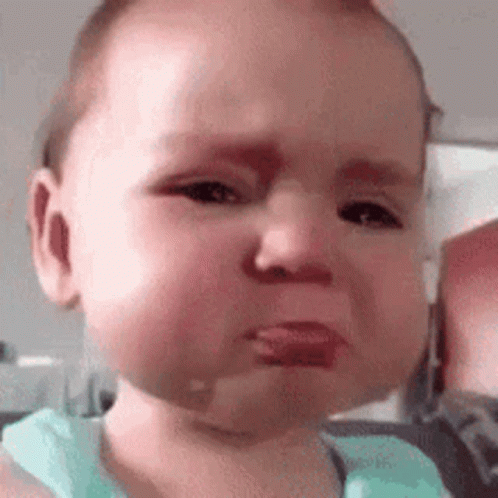

In [133]:
# Perform plane segmentation
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                        ransac_n=3,
                                        num_iterations=2000)
# Here, distance_threshold is the maximum distance a point can be from the plane to be considered an inlier,
# ransac_n is the number of initial points to sample,
# num_iterations is the number of iterations the algorithm performs.

# inliers contains the indices of the points that belong to the plane
# We can use this to create a new point cloud containing only these points:
plane = pcd.select_by_index(inliers)
plane.paint_uniform_color([0,1,0])

# We can also create a point cloud containing everything else:
pcd = pcd.select_by_index(inliers, invert=True)

# Visualize
o3d.visualization.draw_geometries([pcd])

In [130]:
def bounding_box():
    point_cloud = np.asarray(pcd.points)
    
    # Define the bounding box
    min_x = np.min(point_cloud[:, 0])
    max_x = np.max(point_cloud[:, 0])
    min_y = np.min(point_cloud[:, 1])
    max_y = np.max(point_cloud[:, 1])
    min_z = np.min(point_cloud[:, 2])
    max_z = np.max(point_cloud[:, 2])

    # Expand the bounding box slightly
    padding = 0.5  # for example, 10% of the range

    min_x = padding * min_x
    max_x = padding * max_x
    min_y = padding * min_y
    max_y = padding * max_y
    min_z = padding * min_z

    # Filter the points
    human_points = point_cloud[
        (point_cloud[:, 0] >= min_x) & (point_cloud[:, 0] <= max_x) &
        (point_cloud[:, 1] >= min_y) & (point_cloud[:, 1] <= max_y) &
        (point_cloud[:, 2] >= min_z) & (point_cloud[:, 2] <= max_z)
    ]
    
    human_colors = np.array(pcd.colors)[
        (point_cloud[:, 0] >= min_x) & (point_cloud[:, 0] <= max_x) &
        (point_cloud[:, 1] >= min_y) & (point_cloud[:, 1] <= max_y) &
        (point_cloud[:, 2] >= min_z) & (point_cloud[:, 2] <= max_z)
    ]


    ###
    visualized_point_cloud = o3d.geometry.PointCloud()
    visualized_point_cloud.points = o3d.utility.Vector3dVector(human_points)
    visualized_point_cloud.colors = o3d.utility.Vector3dVector(human_colors)
    
    obb = visualized_point_cloud.get_minimal_oriented_bounding_box()
    obb.color = [0,0,1]
    # abb = visualized_point_cloud.get_oriented_bounding_box()
    # abb.color = [0,1,0]
    o3d.visualization.draw_geometries([visualized_point_cloud, obb])
    
    return visualized_point_cloud

pcd = bounding_box()

In [134]:
def minimalBoundingBox(pcd: o3d.cpu.pybind.geometry.PointCloud, factor=0.1) -> None:
    '''
    Applies a minimal bounding box, isolating the human subject from the scene.
    This helps to remove majority of the unnecessary points.
    
    Args:
        pcd (o3d.cpu.pybind.geometry.PointCloud): PointCloud object
    
    Returns:
        type: o3d.cpu.pybind.geometry.PointCloud'     
    '''
    
    points = np.asarray(pcd.points)
    
    min_x, min_y, min_z = points.min(axis=0)[:3]
    max_x, max_y, max_z = points.max(axis=0)[:3]

    # std dev in each dimension
    std_dev_x, std_dev_y, std_dev_z = np.std(points, axis=0)[:3]

    padding_x = factor * std_dev_x
    padding_y = factor * std_dev_y

    # set to 0 cuz only want to adjust x/y dimensions
    padding_z = 0 

    bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=(min_x - padding_x, min_y - padding_y, min_z - padding_z), 
                                               max_bound=(max_x + padding_x, max_y + padding_y, max_z + padding_z))
    bbox.get_minimal_oriented_bounding_box()
    bbox.color = [1,0,0]

    # Select points within the bounding box
    pcd_in_bbox = pcd.crop(bbox)
    
    o3d.visualization.draw_geometries([bbox, pcd_in_bbox])
    
    return pcd_in_bbox

## TODO! - REVIEW CODE / REFACTOR
def bounding_box_minor(pcd: o3d.cpu.pybind.geometry.PointCloud) -> None:
    '''
    Cleans the floor??
    
    Brain no work 
    
    '''
    
    # Create bounding box:
    bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0, 0.0458]]  # set the bounds
    
    bounding_box_points = list(itertools.product(*bounds))  # create limit points
    bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(
        o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object
    
    _, inliers = pcd.segment_plane(distance_threshold=0.01,
                                          ransac_n=3,
                                          num_iterations=1000)
    plane = pcd.select_by_index(inliers)
    pcd = pcd.select_by_index(inliers, invert=True)
    
    # Crop the point cloud using the bounding box:
    pcd_croped = pcd.crop(bounding_box)
    dists = np.asarray(pcd.compute_point_cloud_distance(pcd_croped))
    indices = np.where(dists > 0.01)[0]
    pcd_cropped_inv = pcd.select_by_index(indices)

    # Display the cropped point cloud:
    # self.visualise(pcd_croped, windowName="pcd cropped")
    # o3d.visualization.draw_geometries([pcd_cropped_inv])
        
    return pcd_cropped_inv


def downsample_clean(pcd: o3d.cpu.pybind.geometry.PointCloud) -> None:
    '''
    Performs downsampling, outlier removal and bounding box removal
    
    Args:
        pcd (o3d.cpu.pybind.geometry.PointCloud): PointCloud object
    
    Returns:
        type: None 
    '''

    # voxel downsampling: reducing overall num of pts
    voxel_size = 0.02
    downsampled = pcd.voxel_down_sample(voxel_size) 
    
    # outlier cleaning
    _, ind = downsampled.remove_statistical_outlier(nb_neighbors=100, std_ratio=2.0)
    cleaned_pcd = downsampled.select_by_index(ind)
    
    # minimal bounding box
    pcd = minimalBoundingBox(cleaned_pcd)
    pcd = bounding_box_minor(pcd)

    # paint removal parts
    epsilon = 0.01
    points = np.asarray(pcd.points)
    indices = np.where(np.abs(points[:, 2] < epsilon))[0]
    
    pcd_in_color = pcd.select_by_index(indices)
    pcd_in_color.paint_uniform_color([1,1,0])
    pcd = pcd.select_by_index(indices, invert=True)
    
    o3d.visualization.draw_geometries([pcd])

    return pcd

pcd = downsample_clean(pcd)

In [10]:
# o3d.visualization.draw_geometries([pcd])

In [135]:
from collections import Counter

def isolateLargestCluster(pcd: o3d.cpu.pybind.geometry.PointCloud, labels: np.ndarray) -> None:
    '''
    Uses DBSCAN to group and isolate the largest point cloud 
       
    Args:
        pcd (o3d.cpu.pybind.geometry.PointCloud): PointCloud object
        labels (np.ndarray): Array of clusters identified by labels
    
    Returns:
        type: o3d.cpu.pybind.geometry.PointCloud
    '''

    # finding the label of largest cluster + ignoring noisy points labeled -1
    counts = Counter(labels)
    largest_cluster_label = max(counts.items(), key=lambda x: x[1] if x[0] != -1 else -1)[0]

    # get all pts / colors of largest cluster
    largest_cluster_points = np.array(pcd.points)[labels == largest_cluster_label]
    largest_cluster_colors = np.array(pcd.colors)[labels == largest_cluster_label]
    
    # new point cloud from the largest cluster pts w/ colors
    largest_cluster_pcd = o3d.geometry.PointCloud()
    largest_cluster_pcd.points = o3d.utility.Vector3dVector(largest_cluster_points)
    largest_cluster_pcd.colors = o3d.utility.Vector3dVector(largest_cluster_colors)
    
    return largest_cluster_pcd
    
labels = np.array(pcd.cluster_dbscan(eps=0.05, min_points=3, print_progress=True))
pcd = isolateLargestCluster(pcd, labels)
o3d.visualization.draw_geometries([pcd])